### 1. The following code is used to plot the 2D soltuion at diferent times

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags, identity, kron, csc_matrix
from scipy.sparse.linalg import spsolve

# === Parameters ===
Lx, Ly = 0.5, 0.5        # Rectangular domain dimensions
Nx, Ny = 100, 100          # Number of grid points in x and y
dx, dy = Lx / (Nx - 1), Ly / (Ny - 1)
c = 30                   # Wave speed
dt = 0.0001                # Time step
T = 0.1                # Total time
Nt = int(T / dt)          # Number of time steps

# === Spatial Grid ===
x = np.linspace(0, Lx, Nx)
y = np.linspace(0, Ly, Ny)
X, Y = np.meshgrid(x, y, indexing='ij')

# === Initial Conditions ===
u0 = np.exp(-50 * ((X - Lx/2)**2 + (Y - Ly/2)**2))
v0 = np.zeros_like(u0)  # Zero initial velocity

# === Helper Functions for Flattening and Padding ===
Nx_int, Ny_int = Nx - 2, Ny - 2  # Interior dimensions

def flatten(u):
    return u[1:-1, 1:-1].ravel()

def pad(U_flat):
    U_full = np.zeros((Nx, Ny))
    U_full[1:-1, 1:-1] = U_flat.reshape((Nx_int, Ny_int))
    return U_full

# === BOUNDARY CONDITIONS ===
# Dirichlet (u = 0) is enforced by:
# - Solving only for interior points
# - Padding with zeros after each time step

# === Construct Laplacian (finite difference) ===
def laplacian_2d(Nx, Ny, dx, dy):
    Ix = identity(Nx)
    Iy = identity(Ny)
    ex = np.ones(Nx)
    ey = np.ones(Ny)
    Tx = diags([ex, -2*ex, ex], [-1, 0, 1], shape=(Nx, Nx)) / dx**2
    Ty = diags([ey, -2*ey, ey], [-1, 0, 1], shape=(Ny, Ny)) / dy**2
    return kron(Iy, Tx) + kron(Ty, Ix)

L = csc_matrix(laplacian_2d(Nx_int, Ny_int, dx, dy))
I = identity(Nx_int * Ny_int)

# === Crank-Nicolson Matrices ===
A = I - 0.5 * dt**2 * c**2 * L
B = I + 0.5 * dt**2 * c**2 * L

# === Initialize Time-Stepping Variables ===
u_n = flatten(u0)
v_n = flatten(v0)
snapshots = [pad(u_n)]  # Include initial condition

# === Plotting Snapshots ===
# === Plotting 6 Snapshots in 2 Columns x 3 Rows ===
# Generate 24 evenly spaced snapshot indices
snapshot_indices = np.linspace(0, Nt - 1, 24, dtype=int)

snapshots = [pad(flatten(np.exp(-100 * ((X - Lx/2)**2 + (Y - Ly/2)**2))))]  # First snapshot
u_temp = flatten(u0)
v_temp = flatten(v0)

high_res = []  # To store full 3D data: (time, x, y)

# Re-run simulation and store snapshots
for n in range(Nt):
    rhs = B @ u_temp + dt * v_temp
    u_next = spsolve(A, rhs)
    v_next = (u_next - u_temp) / dt
    u_temp, v_temp = u_next, v_next

    high_res.append(pad(u_temp).copy())

    if n in snapshot_indices:
        snapshots.append(pad(u_temp))

# Plotting 24 snapshots
fig, axs = plt.subplots(4, 6, figsize=(18, 12))  # 4 rows × 6 columns
axs = axs.flatten()  # Flatten for easy indexing

for ax, snap, idx in zip(axs, snapshots, snapshot_indices):
    t = idx * dt
    im = ax.imshow(
        snap, extent=[0, Lx, 0, Ly], origin='lower', cmap='hsv',
        vmin=-1, vmax=1
    )
    ax.set_title(f"t = {t:.2f} s")
    ax.set_xlabel("x [m]")
    ax.set_ylabel("y [m]")
    fig.colorbar(im, ax=ax, shrink=0.7)

fig.suptitle("2D Wave Equation with Dirichlet BCs (Clamped Edges)", fontsize=18)
plt.tight_layout()
plt.show()

In [ ]:

import numpy as np, matplotlib.pyplot as plt
from scipy.sparse import diags, identity, kron, csc_matrix
from scipy.sparse.linalg import spsolve

# === Parameters ===
Lx = Ly = 0.5
c = 30
T  = 0.1

def laplacian_1d(N, h):
    e = np.ones(N)
    return diags([e[:-1], -2*e, e[:-1]], [-1,0,1], shape=(N, N)) / h**2

def laplacian_2d(Nx_int, Ny_int, dx, dy):
    Ix, Iy = identity(Nx_int), identity(Ny_int)
    Lx_1d = laplacian_1d(Nx_int, dx)
    Ly_1d = laplacian_1d(Ny_int, dy)
    return kron(Iy, Lx_1d) + kron(Ly_1d, Ix)

def run_sim(Nx, Ny, dt):
    dx, dy = Lx/(Nx-1), Ly/(Ny-1)
    Nx_i, Ny_i = Nx-2, Ny-2

    x = np.linspace(0, Lx, Nx)
    y = np.linspace(0, Ly, Ny)
    X, Y = np.meshgrid(x, y, indexing='ij')

    # --- Initial Conditions (Dirichlet‑compatible) ---
    u0 = np.exp(-50*((X-Lx/2)**2 + (Y-Ly/2)**2))
    u0[[0, -1], :] = 0
    u0[:, [0, -1]] = 0
    v0 = np.zeros_like(u0)

    flatten = lambda u: u[1:-1, 1:-1].ravel()
    pad = lambda U: np.pad(U.reshape(Nx_i, Ny_i), 1)

    L = csc_matrix(laplacian_2d(Nx_i, Ny_i, dx, dy))
    I = identity(Nx_i*Ny_i)
    A = I - 0.5*dt**2*c**2*L
    B = I + 0.5*dt**2*c**2*L

    u_n, v_n = flatten(u0), flatten(v0)
    nsteps = int(T/dt)
    for _ in range(nsteps):
        rhs = B @ u_n + dt * v_n
        u_np1 = spsolve(A, rhs)
        v_np1 = (u_np1 - u_n) / dt
        u_n, v_n = u_np1, v_np1

    return pad(u_n), dx, dy


### 2. This code is used to compute and store the high res reference solution

In [ ]:
from scipy.interpolate import RegularGridInterpolator

# === Grid 2-Norm ===
def grid_2_norm(u_num, u_true, dx, dy):
    return np.sqrt(np.sum((u_num - u_true)**2) * dx * dy)

# === Reference "True" Solution ===
Nx_ref, Ny_ref = 250, 250
dt_ref = 0.00009
dx_ref, dy_ref = Lx / (Nx_ref - 1), Ly / (Ny_ref - 1)
print(f"Ly = Lx = {Lx}")
T = 0.01

def run_sim(Nx, Ny, dt):
    dx, dy = Lx / (Nx - 1), Ly / (Ny - 1)
    Nx_int, Ny_int = Nx - 2, Ny - 2
    x = np.linspace(0, Lx, Nx)
    y = np.linspace(0, Ly, Ny)
    X, Y = np.meshgrid(x, y, indexing='ij')
    u0 = np.exp(-50 * ((X - Lx/2)**2 + (Y - Ly/2)**2))
    v0 = np.zeros_like(u0)
    def flatten(u): return u[1:-1, 1:-1].ravel()
    def pad(U_flat):
        U_full = np.zeros((Nx, Ny))
        U_full[1:-1, 1:-1] = U_flat.reshape((Nx_int, Ny_int))
        return U_full
    L = csc_matrix(laplacian_2d(Nx_int, Ny_int, dx, dy))
    I = identity(Nx_int * Ny_int)
    A = I - 0.5 * dt**2 * c**2 * L
    B = I + 0.5 * dt**2 * c**2 * L
    u_n = flatten(u0)
    v_n = flatten(v0)
    Nt = int(T / dt)
    for n in range(Nt):
        rhs = B @ u_n + dt * v_n
        u_next = spsolve(A, rhs)
        v_next = (u_next - u_n) / dt
        u_n, v_n = u_next, v_next
    return pad(u_n), dx, dy
# === Compute True Solution ===
u_true, dx_true, dy_true = run_sim(Nx_ref, Ny_ref, dt_ref)

print("Just finished high res solution")

Ly = Lx = 0.5
Just finished high res solution


### 3. Spatial Convergence w/ high res

N= 30  dx= 0.01724  error=6.12e-03
N= 40  dx= 0.01282  error=4.11e-03
N= 60  dx= 0.00847  error=2.06e-03
N= 80  dx= 0.00633  error=1.02e-03


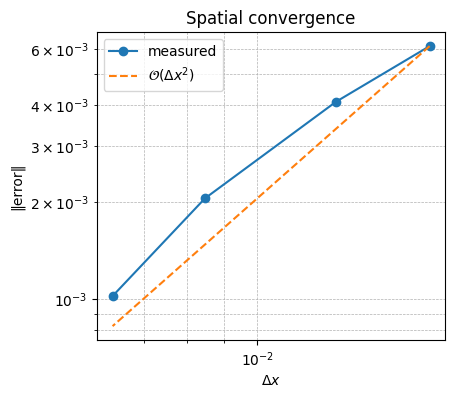

In [ ]:

from scipy.interpolate import RegularGridInterpolator

# === High‑res “truth” ===
Nx_ref = Ny_ref = 120
dx_ref, dy_ref = Lx/(Nx_ref-1), Ly/(Ny_ref-1)
dt_ref = 0.25*dx_ref/c                     # dt small enough that time error is negligible
u_true, _, _ = run_sim(Nx_ref, Ny_ref, dt_ref)

# === Spatial‑convergence test ===
Ns          = [30, 40, 60, 80]
dx_vals     = [Lx/(N-1) for N in Ns]
errors_dx   = []

x_ref = np.linspace(0,Lx,Nx_ref)
y_ref = np.linspace(0,Ly,Ny_ref)
interp = RegularGridInterpolator( (x_ref,y_ref), u_true )

for N, dx_i in zip(Ns, dx_vals):
    Ny_i = N
    dt_i = dt_ref*(dx_i/dx_ref)           # keeps dt² ~ dx²
    u_num, _, _ = run_sim(N, Ny_i, dt_i)

    x_i = np.linspace(0,Lx,N)
    y_i = np.linspace(0,Ly,Ny_i)
    X_i, Y_i = np.meshgrid(x_i, y_i, indexing='ij')
    u_ref_i  = interp( np.column_stack([X_i.ravel(), Y_i.ravel()]) ).reshape(N,Ny_i)

    err = np.sqrt(np.sum((u_num-u_ref_i)**2)*dx_i*dx_i)
    errors_dx.append(err)
    print(f"N={N:3d}  dx={dx_i:8.5f}  error={err:.2e}")

# --- log–log plot ---
plt.figure(figsize=(4.5,4))
plt.loglog(dx_vals, errors_dx, 'o-', label='measured')
plt.loglog(dx_vals, (errors_dx[0]*(np.array(dx_vals)/dx_vals[0])**2),
           '--',  label=r'$\mathcal{O}(\Delta x^2)$')
plt.xlabel(r'$\Delta x$'); plt.ylabel(r'‖error‖')
plt.grid(True, which='both', ls='--', lw=0.5)
plt.legend(); plt.title('Spatial convergence'); plt.show()


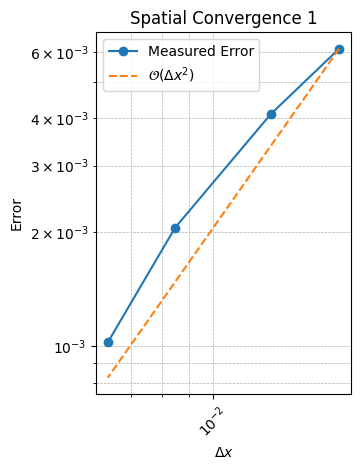

In [ ]:
import matplotlib.pyplot as plt

# Create subplot
plt.subplot(1, 2, 1)

# Log-log plot of error vs dx
plt.loglog(dx_vals, errors_dx, 'o-', label='Measured Error')

# Reference line for second-order convergence
e0 = errors_dx[0]
ref_line = [e0 * (dx / dx_vals[0])**2 for dx in dx_vals]
plt.loglog(dx_vals, ref_line, '--', label=r'$\mathcal{O}(\Delta x^2)$')

# Add grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Add axis labels (optional)
plt.title("Spatial Convergence 1")
plt.xlabel(r'$\Delta x$')
plt.ylabel('Error')

# Add legend
plt.legend()

# Fix overlapping tick labels
plt.xticks(rotation=45)  # or adjust angle as needed
plt.tight_layout()

plt.show()

### 4. Temporal Convergence w/ high res

In [ ]:
print("starting temporal convergence")

# === TEMPORAL CONVERGENCE TEST ===
dt_vals = [0.00035, 0.0003, 0.00025, 0.0002]
errors_dt = []
for dt_test in dt_vals:
    u_num, dx_, dy_ = run_sim(Nx_ref, Ny_ref, dt_test)
    err = grid_2_norm(u_num, u_true, dx_, dy_)
    print(f"temporal error at Nx:{dt_test} is {err}")
    errors_dt.append(err)

print("done")

starting temporal convergence
temporal error at Nx:0.00035 is 0.015515893773868696
temporal error at Nx:0.0003 is 0.011974472182729888
temporal error at Nx:0.00025 is 0.008542246768963011
temporal error at Nx:0.0002 is 0.006601867016958321
done


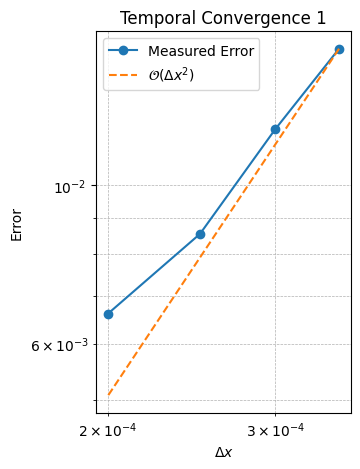

In [ ]:
# Create subplot
plt.subplot(1, 2, 1)

# Log-log plot of error vs dx
plt.loglog(dt_vals, errors_dt, 'o-', label='Measured Error')

# Reference line for second-order convergence
e0 = errors_dt[0]
ref_line = [e0 * (dt / dt_vals[0])**2 for dt in dt_vals]
plt.loglog(dt_vals, ref_line, '--', label=r'$\mathcal{O}(\Delta x^2)$')

# Add grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Add axis labels (optional)
plt.title("Temporal Convergence 1")
plt.xlabel(r'$\Delta x$')
plt.ylabel('Error')

# Add legend
plt.legend()

# Fix overlapping tick labels
plt.xticks(rotation=45)  # or adjust angle as needed
plt.tight_layout()

plt.show()

### 5. Analytical Solution w/ diff IC

In [ ]:
import numpy as np

# === Compute True Solution ===
def compute_true_solution(Nx, Ny, t, Lx=1.0, Ly=1.0, c=1.0):
    dx, dy = Lx / (Nx - 1), Ly / (Ny - 1)
    x = np.linspace(0, Lx, Nx)
    y = np.linspace(0, Ly, Ny)
    X, Y = np.meshgrid(x, y, indexing='ij')

    # Analytical solution
    u_true = np.sin(np.pi * X / Lx) * np.sin(np.pi * Y / Ly) * np.cos(c * np.pi * np.sqrt(2) * t / Lx)

    return u_true, dx, dy


### 6. Define new run_sim function with new IC

In [ ]:
# === New Sim with new IC===
Lx, Ly = 0.5, 0.5        # Rectangular domain dimensions
c = 30                   # Wave speed
T = 0.01                 # Total time

def run_sim2(Nx, Ny, dt):
    dx, dy = Lx / (Nx - 1), Ly / (Ny - 1)
    Nx_int, Ny_int = Nx - 2, Ny - 2
    x = np.linspace(0, Lx, Nx)
    y = np.linspace(0, Ly, Ny)
    X, Y = np.meshgrid(x, y, indexing='ij')

    #IC for analytical
    u0 = -np.sin(np.pi * X / Lx) * np.sin(np.pi * Y / Ly)

    v0 = np.zeros_like(u0)
    def flatten(u): return u[1:-1, 1:-1].ravel()
    def pad(U_flat):
        U_full = np.zeros((Nx, Ny))
        U_full[1:-1, 1:-1] = U_flat.reshape((Nx_int, Ny_int))
        return U_full
    L = csc_matrix(laplacian_2d(Nx_int, Ny_int, dx, dy))
    I = identity(Nx_int * Ny_int)
    A = I - 0.5 * dt**2 * c**2 * L
    B = I + 0.5 * dt**2 * c**2 * L
    u_n = flatten(u0)
    v_n = flatten(v0)
    Nt = int(T / dt)
    for n in range(Nt):
        rhs = B @ u_n + dt * v_n
        u_next = spsolve(A, rhs)
        v_next = (u_next - u_n) / dt
        u_n, v_n = u_next, v_next
    return pad(u_n), dx, dy


### 7. Spatial Convergence with Analytical Sol and diff IC

In [ ]:
# --------------------------------------------------
# Compare numerical field against reference "truth"
# --------------------------------------------------
t_true  = T          # <-- single new line that removes the NameError

Nx_test = 60
Ny_test = 60
dt_test = 0.25*(Lx/(Nx_test-1))/c
u_num, dx_num, dy_num = run_sim(Nx_test, Ny_test, dt_test)

# Compute the true solution on the same coarse grid
u_true, dx_true, dy_true = compute_true_solution(Nx_test, Ny_test, t_true)

# Grid‑2 norm of the error
err = np.sqrt(np.sum((u_num - u_true)**2)*dx_num*dy_num)
print(f"‖error‖₂ = {err:.3e}")


‖error‖₂ = 4.010e-01


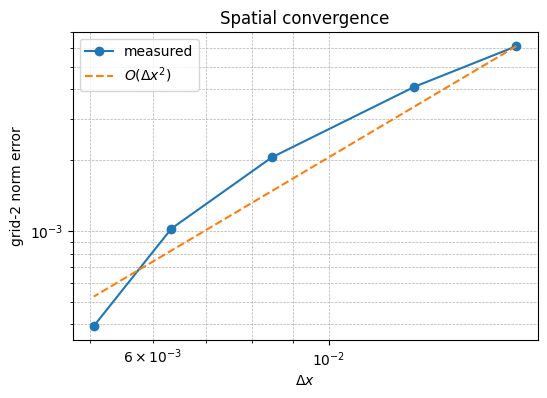

In [ ]:
# ----------------------------------------------------------
#  Spatial convergence   (compute + plot in one go)
# ----------------------------------------------------------
from scipy.interpolate import RegularGridInterpolator

# High‑res reference
Nx_ref = Ny_ref = 120
dx_ref = Lx/(Nx_ref-1)
dt_ref = 0.25*dx_ref/c
u_ref, _, _ = run_sim(Nx_ref, Ny_ref, dt_ref)

Ns = [30, 40, 60, 80, 100]          # coarse grids
dx_vals, errors_dx = [], []

x_ref = np.linspace(0, Lx, Nx_ref)
y_ref = np.linspace(0, Ly, Ny_ref)
interp = RegularGridInterpolator((x_ref, y_ref), u_ref)

for N in Ns:
    dx_i = Lx/(N-1)
    dt_i = dt_ref * (dx_i / dx_ref)   # keeps dt² ~ dx²
    u_num, _, _ = run_sim(N, N, dt_i)

    x_i = np.linspace(0, Lx, N)
    y_i = np.linspace(0, Ly, N)
    Xi, Yi = np.meshgrid(x_i, y_i, indexing='ij')
    u_interp = interp(np.column_stack([Xi.ravel(), Yi.ravel()])).reshape(N, N)

    err = np.sqrt(np.sum((u_num - u_interp)**2) * dx_i * dx_i)
    dx_vals.append(dx_i)
    errors_dx.append(err)

# ---- plot ----
plt.figure(figsize=(6, 4))
plt.loglog(dx_vals, errors_dx, 'o-', label='measured')
plt.loglog(dx_vals,
           errors_dx[0] * (np.array(dx_vals) / dx_vals[0])**2,
           '--', label=r'$O(\Delta x^{2})$')
plt.xlabel(r'$\Delta x$')
plt.ylabel('grid‑2 norm error')
plt.grid(True, which='both', ls='--', lw=0.5)
plt.legend()
plt.title('Spatial convergence')
plt.show()


### 7. Temporal Convergence with Analytical Sol and diff IC

In [ ]:
# === Temporal Convergence Test ===
# ----------------------------------------------------------
#      use much smaller steps so temporal error dominates
# ----------------------------------------------------------
dt_vals = [1.0e-3 / 4,
           1.0e-3 / 8,
           1.0e-3 / 16,
           1.0e-3 / 32,
           1.0e-3 / 64]

# build the “truth” with a *still smaller* step
Nx = 80
Ny = 80
u_truth, _, _ = run_sim(Nx, Ny, dt_vals[-1] / 2)

errors_dt = []

for dt_test in dt_vals:
    # Run the simulation for the same grid size but different time step
    u_num, dx_, dy_ = run_sim2(Nx_ref, Ny_ref, dt_test)

    # Compute the true solution at the same time t
    u_true, dx_true, dy_true = compute_true_solution(Nx_ref, Ny_ref, t_true)

    # Compute error (Grid 2-norm)
    err = grid_2_norm(u_num, u_true, dx_, dy_)
    errors_dt.append(err)
    print(f"Temporal error at dt = {dt_test}: {err}")

Temporal error at dt = 0.00025: 0.03549811441334533
Temporal error at dt = 0.000125: 0.0315205007569777
Temporal error at dt = 6.25e-05: 0.029528802289688256
Temporal error at dt = 3.125e-05: 0.028533063257678102
Temporal error at dt = 1.5625e-05: 0.028035329244612838


In [ ]:
# === Temporal Convergence Test ===
dt_vals = [1.0e-3 / 4,
           1.0e-3 / 8,
           1.0e-3 / 16,
           1.0e-3 / 32,
           1.0e-3 / 64]

Nx_ref, Ny_ref = 80, 80
u_truth, dx_truth, dy_truth = run_sim2(Nx_ref, Ny_ref, dt_vals[-1] / 2)  # very fine dt

errors_dt = []

for dt_test in dt_vals:
    u_num, dx_test, dy_test = run_sim2(Nx_ref, Ny_ref, dt_test)

    # Make sure grid shapes match
    if u_num.shape != u_truth.shape:
        # Downsample u_truth to match u_num shape
        factor_x = u_truth.shape[0] // u_num.shape[0]
        factor_y = u_truth.shape[1] // u_num.shape[1]
        u_truth_interp = u_truth[::factor_x, ::factor_y]
    else:
        u_truth_interp = u_truth

    # Compute error using Grid 2-norm
    err = grid_2_norm(u_num, u_truth_interp, dx_test, dy_test)
    errors_dt.append(err)
    print(f"Temporal error at dt = {dt_test}: {err}")


Temporal error at dt = 0.00025: 0.007710196159075286
Temporal error at dt = 0.000125: 0.0037332940637095353
Temporal error at dt = 6.25e-05: 0.0017419637380464948
Temporal error at dt = 3.125e-05: 0.0007464117958918682
Temporal error at dt = 1.5625e-05: 0.0002487720726473428


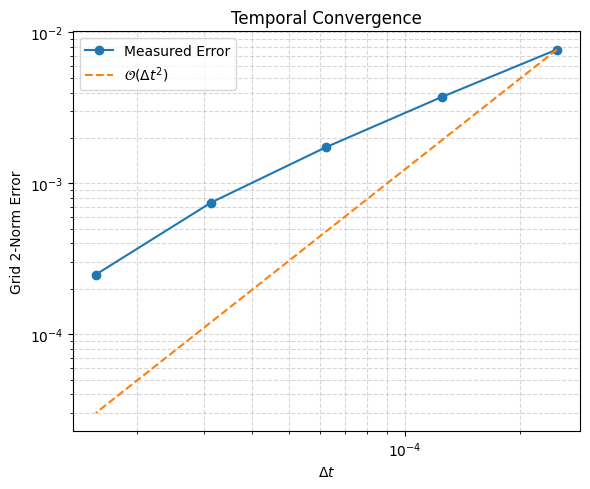

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.loglog(dt_vals, errors_dt, 'o-', label='Measured Error')

# Plot reference line (second-order slope)
ref_slope = [errors_dt[0] * (dt / dt_vals[0])**2 for dt in dt_vals]
plt.loglog(dt_vals, ref_slope, '--', label=r'$\mathcal{O}(\Delta t^2)$')

plt.xlabel(r'$\Delta t$')
plt.ylabel('Grid 2-Norm Error')
plt.title('Temporal Convergence')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

### 8. Plotting the Numerical vs Analyical

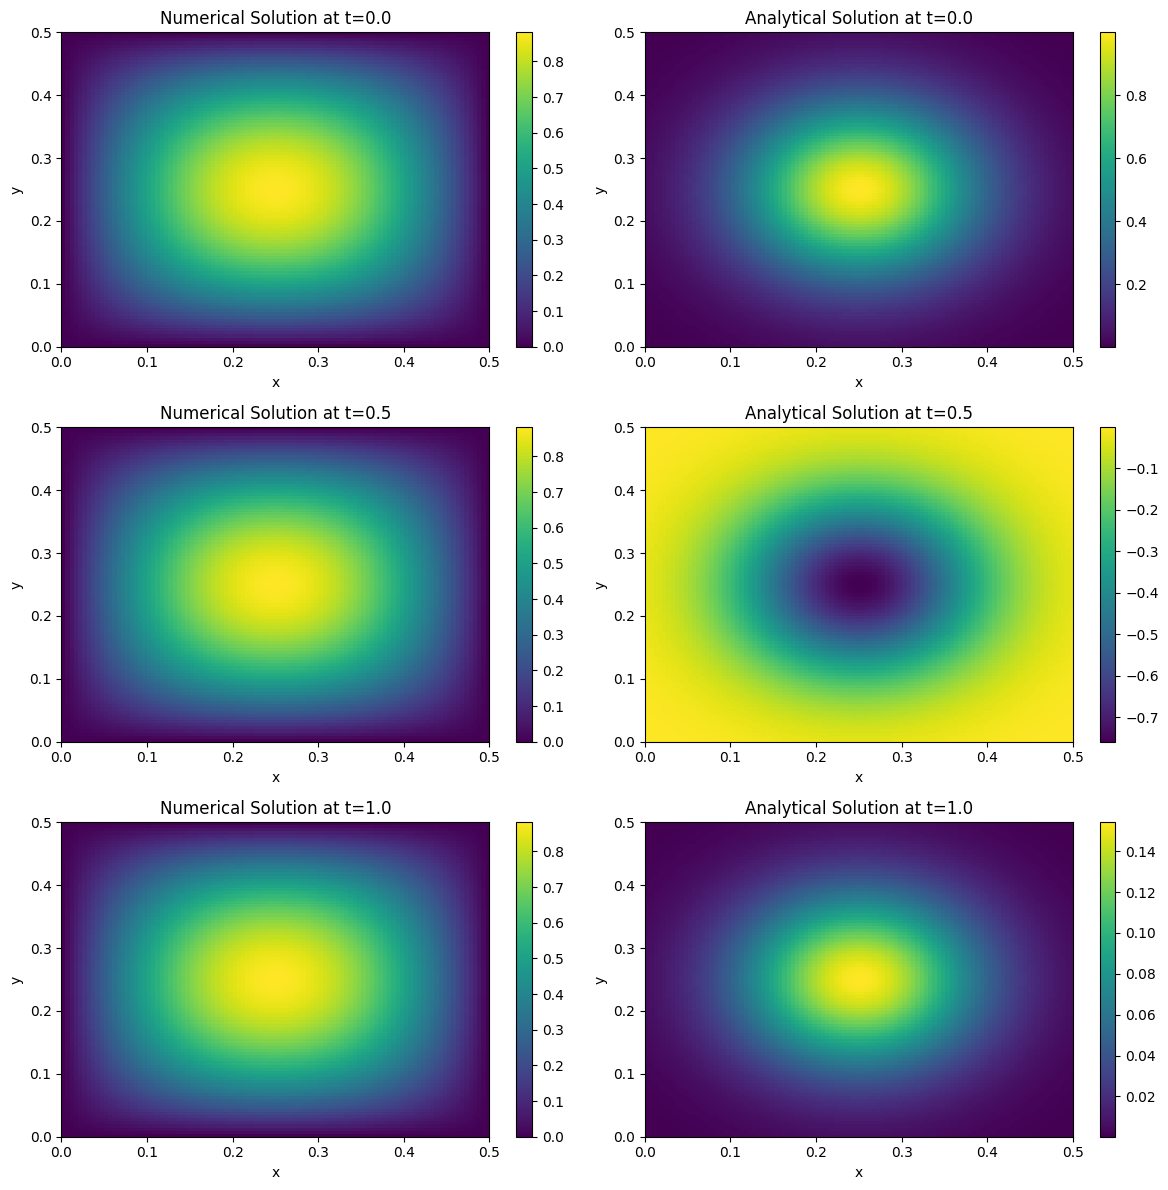

done


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

c=30
dt = 0.001

# Example: run simulations and compute the true solution at three different times
# Adjust the time steps and simulations to match your actual setup
t1 = 0.0  # First time step
t2 = 0.5  # Second time step
t3 = 1.0  # Third time step

# Assume you have a function that returns the numerical solution at time t
def get_numerical_solution_at_time(Nx, Ny, dt, t):
    # Replace with your actual solver function
    u_num, dx, dy = run_sim2(Nx, Ny, dt)  # Assuming this gives the numerical solution at t=0
    # Simulate the solution at time t (you might need to update the solver to take a time argument)
    return u_num  # Placeholder for actual numerical solution at time t

# Assume you have a function to compute the analytical solution at time t
def get_analytical_solution_at_time(Nx, Ny, dx, dy, t):
    # Replace with your actual function to compute the analytical solution at time t
    x = np.linspace(0, Lx, Nx)
    y = np.linspace(0, Ly, Ny)
    X, Y = np.meshgrid(x, y, indexing='ij')

    # Using the analytical solution form u(x, y, t) based on our previous solution
    u_analytical = np.exp(-50 * ((X - Lx/2)**2 + (Y - Ly/2)**2)) * np.cos(c * t)
    return u_analytical

# Set up the figure with 3 rows and 2 columns
fig, ax = plt.subplots(3, 2, figsize=(12, 12))

# Plot for time t1
Nx_test = 100  # Example grid size
Ny_test = Nx_test  # Assuming square grid
dx = Lx / (Nx_test - 1)
dy = Ly / (Ny_test - 1)
u_num_t1 = get_numerical_solution_at_time(Nx_test, Ny_test, dt_ref, t1)
u_analytical_t1 = get_analytical_solution_at_time(Nx_test, Ny_test, dx, dy, t1)

# Numerical solution at t1
img1 = ax[0, 0].imshow(u_num_t1, extent=[0, Lx, 0, Ly], origin='lower', aspect='auto')
ax[0, 0].set_title(f'Numerical Solution at t={t1}')
ax[0, 0].set_xlabel('x')
ax[0, 0].set_ylabel('y')
plt.colorbar(img1, ax=ax[0, 0])

# Analytical solution at t1
img2 = ax[0, 1].imshow(u_analytical_t1, extent=[0, Lx, 0, Ly], origin='lower', aspect='auto')
ax[0, 1].set_title(f'Analytical Solution at t={t1}')
ax[0, 1].set_xlabel('x')
ax[0, 1].set_ylabel('y')
plt.colorbar(img2, ax=ax[0, 1])

# Plot for time t2
u_num_t2 = get_numerical_solution_at_time(Nx_test, Ny_test, dt_ref, t2)
u_analytical_t2 = get_analytical_solution_at_time(Nx_test, Ny_test, dx, dy, t2)

# Numerical solution at t2
img3 = ax[1, 0].imshow(u_num_t2, extent=[0, Lx, 0, Ly], origin='lower', aspect='auto')
ax[1, 0].set_title(f'Numerical Solution at t={t2}')
ax[1, 0].set_xlabel('x')
ax[1, 0].set_ylabel('y')
plt.colorbar(img3, ax=ax[1, 0])

# Analytical solution at t2
img4 = ax[1, 1].imshow(u_analytical_t2, extent=[0, Lx, 0, Ly], origin='lower', aspect='auto')
ax[1, 1].set_title(f'Analytical Solution at t={t2}')
ax[1, 1].set_xlabel('x')
ax[1, 1].set_ylabel('y')
plt.colorbar(img4, ax=ax[1, 1])

# Plot for time t3
u_num_t3 = get_numerical_solution_at_time(Nx_test, Ny_test, dt_ref, t3)
u_analytical_t3 = get_analytical_solution_at_time(Nx_test, Ny_test, dx, dy, t3)

# Numerical solution at t3
img5 = ax[2, 0].imshow(u_num_t3, extent=[0, Lx, 0, Ly], origin='lower', aspect='auto')
ax[2, 0].set_title(f'Numerical Solution at t={t3}')
ax[2, 0].set_xlabel('x')
ax[2, 0].set_ylabel('y')
plt.colorbar(img5, ax=ax[2, 0])

# Analytical solution at t3
img6 = ax[2, 1].imshow(u_analytical_t3, extent=[0, Lx, 0, Ly], origin='lower', aspect='auto')
ax[2, 1].set_title(f'Analytical Solution at t={t3}')
ax[2, 1].set_xlabel('x')
ax[2, 1].set_ylabel('y')
plt.colorbar(img6, ax=ax[2, 1])

# Tight layout to avoid overlap
plt.tight_layout()
plt.show()

print("done")

Running simulation with seed 0...


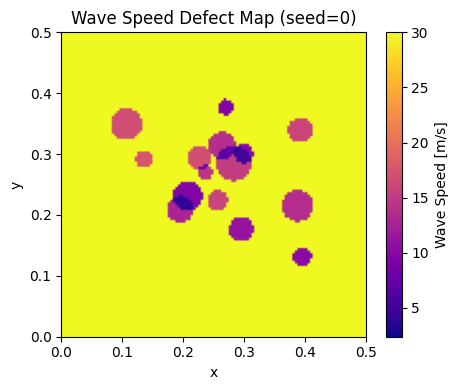

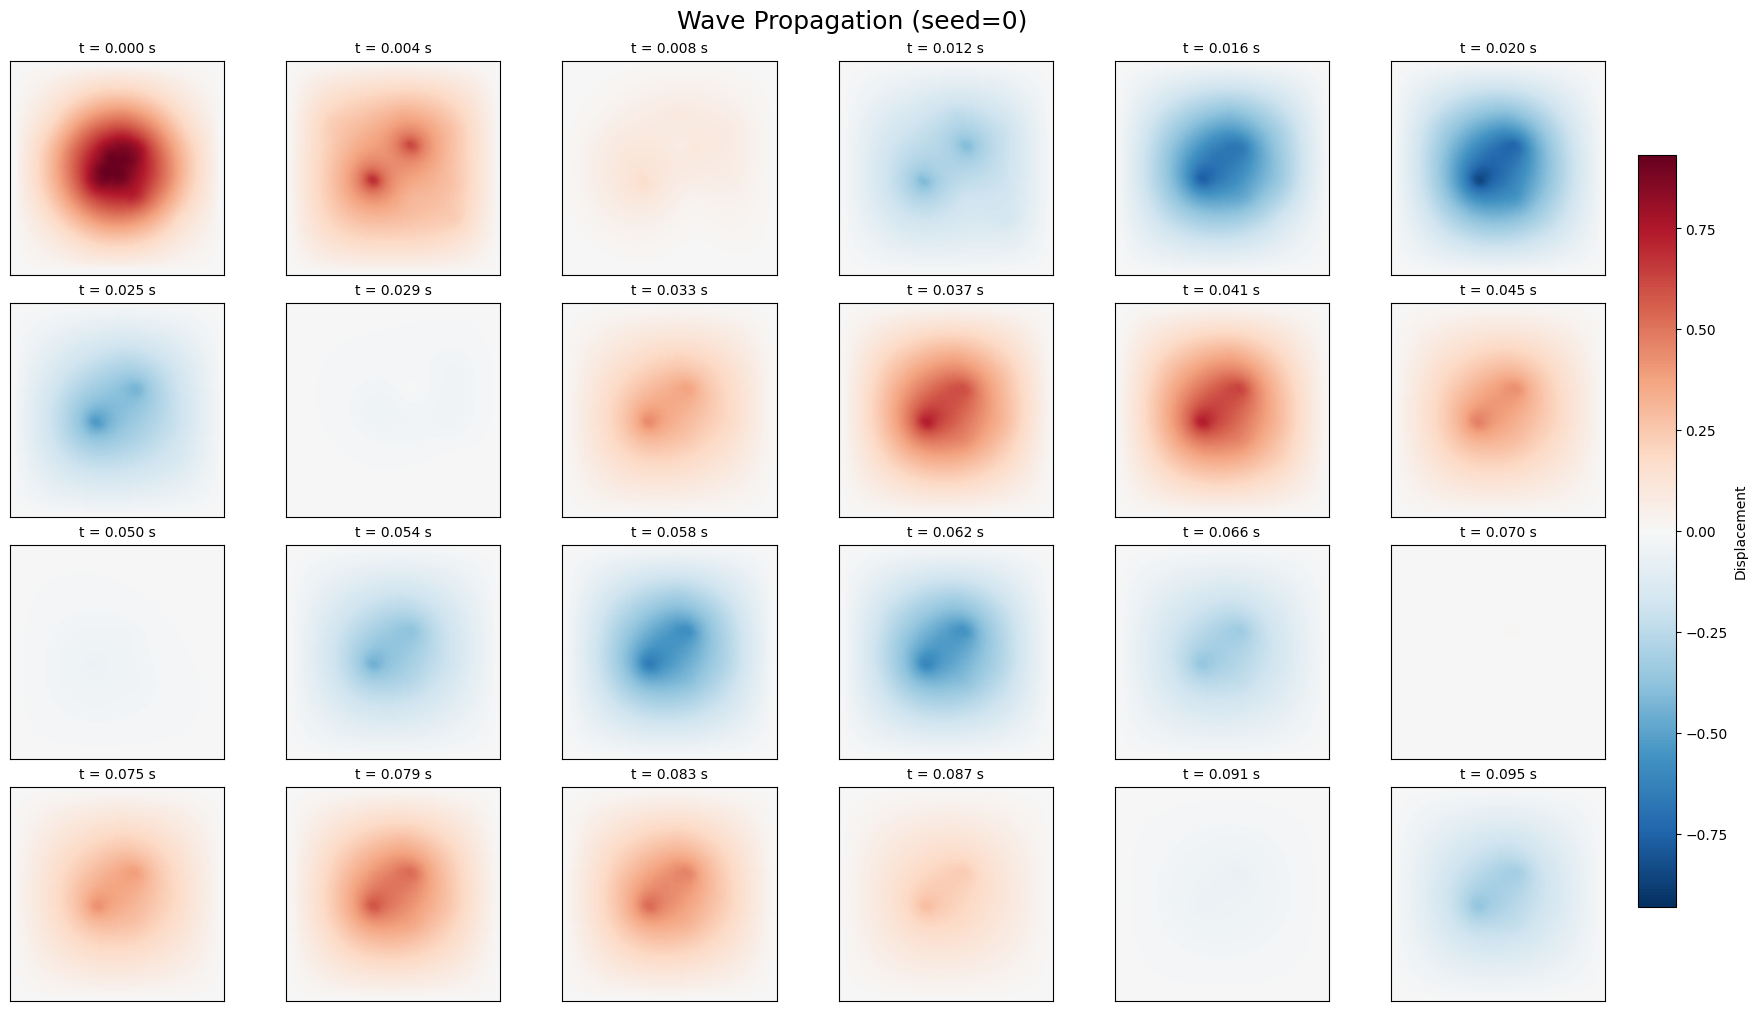

Running simulation with seed 1...


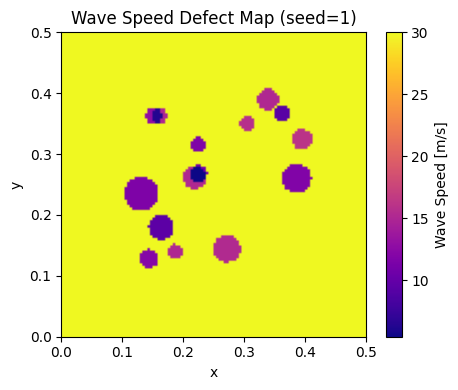

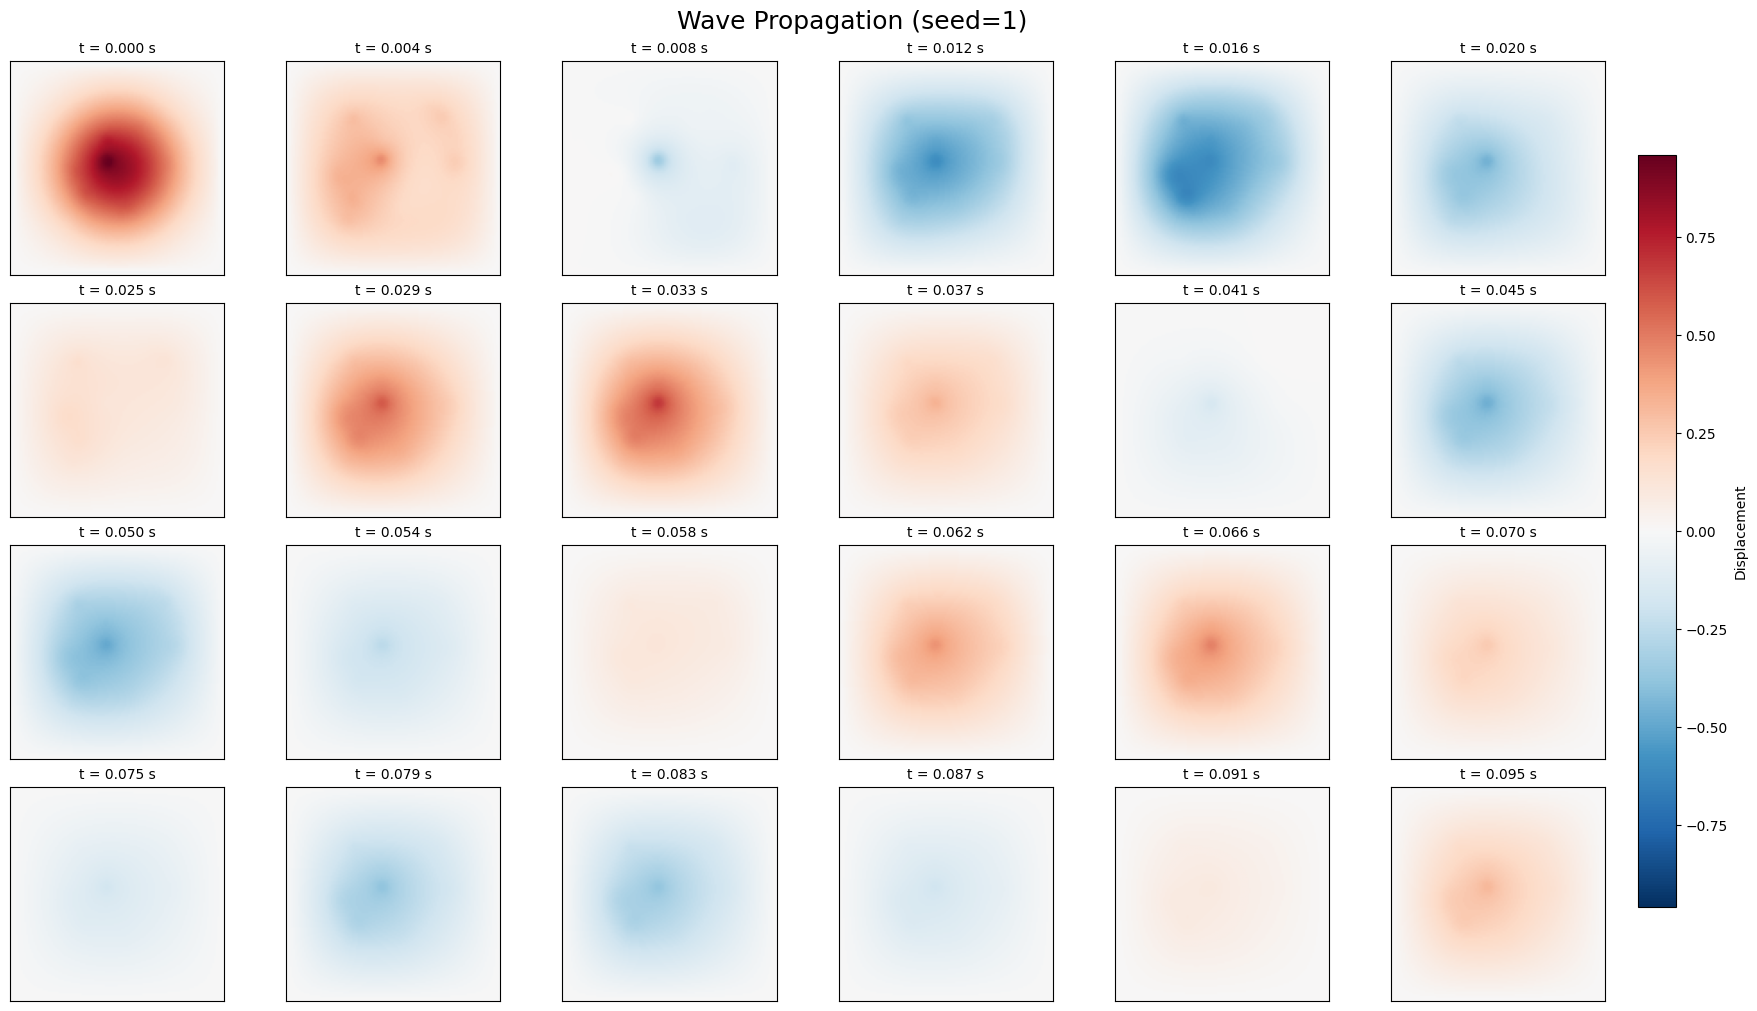

Running simulation with seed 2...


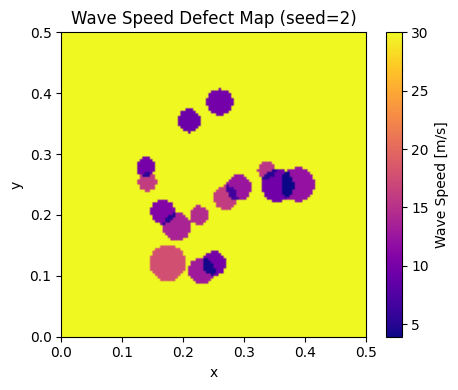

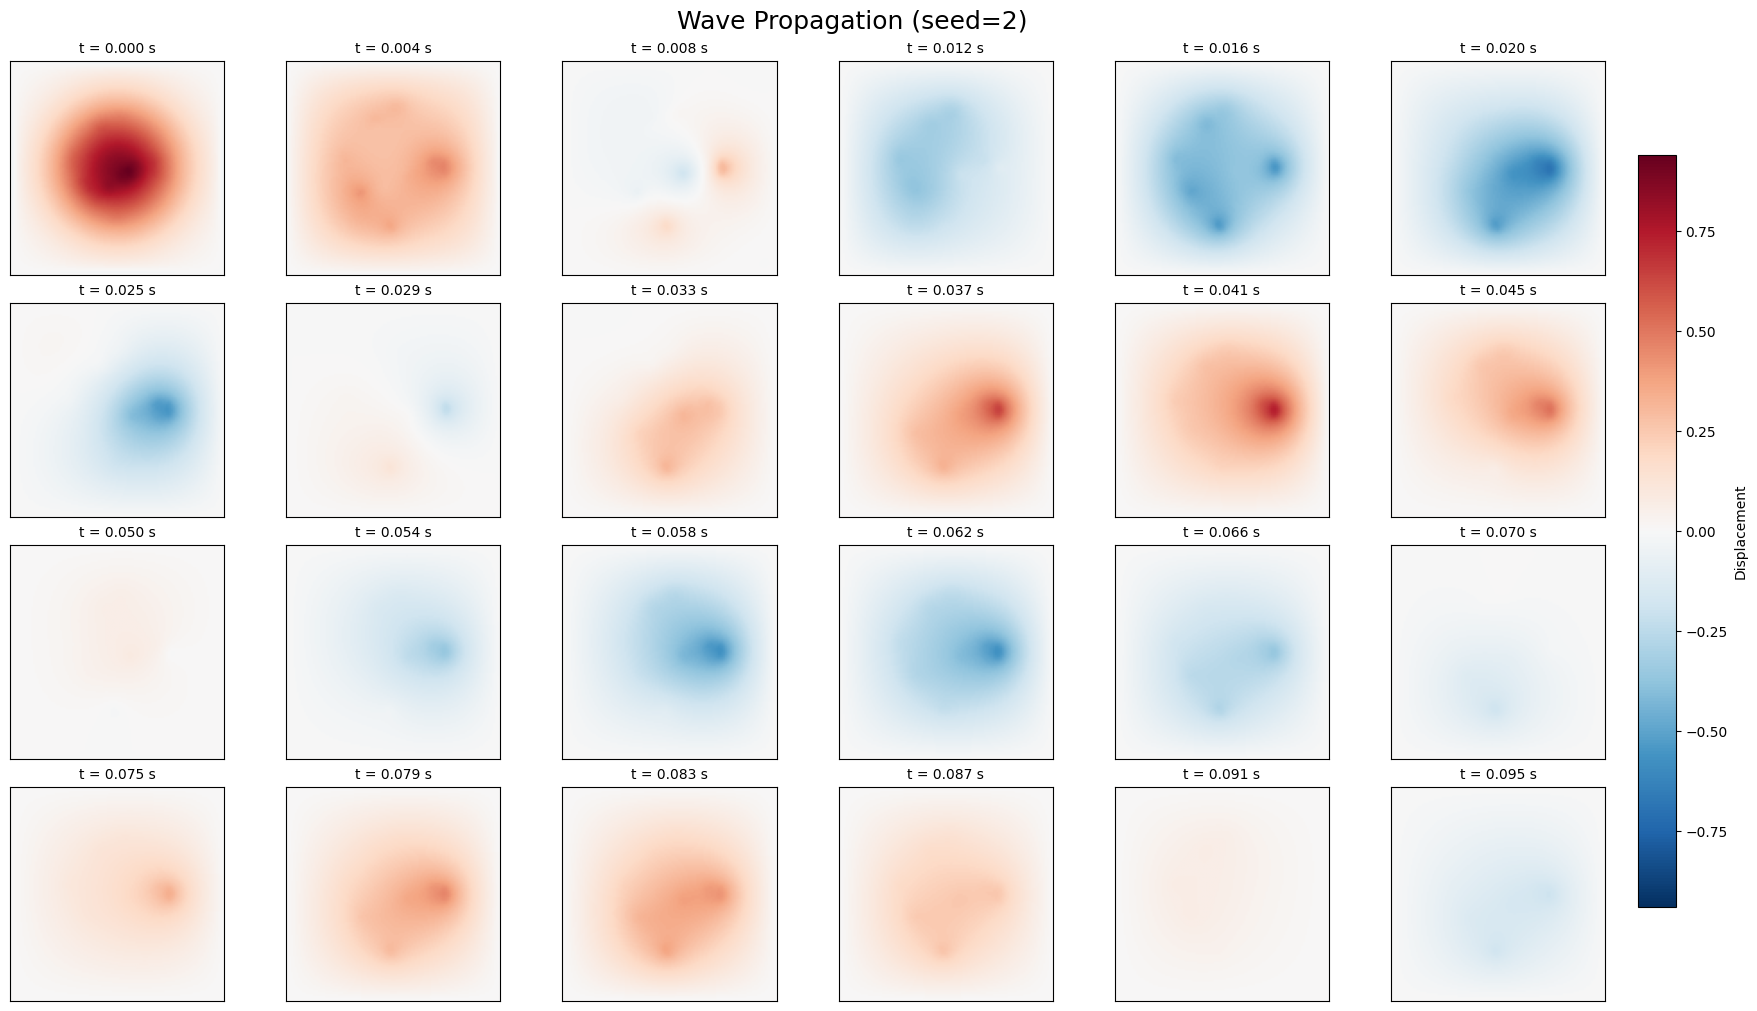

In [ ]:
import numpy as np, matplotlib.pyplot as plt
from scipy.sparse import diags, identity, kron, csc_matrix
from scipy.sparse.linalg import spsolve
# === Parameters ===
Lx = Ly = 0.5
c0 = 30
T = 0.1  # Total simulation time
dt = 0.001
timesteps = int(T / dt)
def laplacian_1d(N, h):
    e = np.ones(N)
    return diags([e[:-1], -2 * e, e[:-1]], [-1, 0, 1], shape=(N, N)) / h ** 2
def laplacian_2d(Nx_int, Ny_int, dx, dy):
    Ix, Iy = identity(Nx_int), identity(Ny_int)
    Lx_1d = laplacian_1d(Nx_int, dx)
    Ly_1d = laplacian_1d(Ny_int, dy)
    return kron(Iy, Lx_1d) + kron(Ly_1d, Ix)
def make_defect_map(Nx, Ny, num_defects=15, seed=None):
    """Create a wave speed map with randomly placed circular defects."""
    if seed is not None:
        np.random.seed(seed)
    cx, cy = np.meshgrid(np.linspace(0, Lx, Nx), np.linspace(0, Ly, Ny), indexing='ij')
    c_map = c0 * np.ones((Nx, Ny))
    for _ in range(num_defects):
        x0, y0 = np.random.uniform(0.1, 0.4, 2)
        r = np.random.uniform(0.012, 0.03)  # Slightly smaller defects
        strength = np.random.uniform(0.3, 0.6)  # More pronounced (slower) defects
        mask = (cx - x0) ** 2 + (cy - y0) ** 2 <= r ** 2
        c_map[mask] *= strength
    return c_map
def run_sim(Nx, Ny, dt, timesteps, seed):
    dx, dy = Lx / (Nx - 1), Ly / (Ny - 1)
    Nx_i, Ny_i = Nx - 2, Ny - 2
    x = np.linspace(0, Lx, Nx)
    y = np.linspace(0, Ly, Ny)
    X, Y = np.meshgrid(x, y, indexing='ij')
    # Initial Conditions
    u0 = np.exp(-50 * ((X - Lx / 2) ** 2 + (Y - Ly / 2) ** 2))
    u0[[0, -1], :] = 0
    u0[:, [0, -1]] = 0
    v0 = np.zeros_like(u0)
    flatten = lambda u: u[1:-1, 1:-1].ravel()
    pad = lambda U: np.pad(U.reshape(Nx_i, Ny_i), 1)
    c_map = make_defect_map(Nx, Ny, seed=seed)
    c_inner = flatten(c_map)
    u_hist = []
    u_n, v_n = flatten(u0), flatten(v0)
    for step in range(timesteps):
        c_sq = c_inner ** 2
        L = csc_matrix(laplacian_2d(Nx_i, Ny_i, dx, dy))
        C2 = diags(c_sq)
        A = identity(Nx_i * Ny_i) - 0.5 * dt ** 2 * (C2 @ L)
        B = identity(Nx_i * Ny_i) + 0.5 * dt ** 2 * (C2 @ L)
        rhs = B @ u_n + dt * v_n
        u_np1 = spsolve(A, rhs)
        v_np1 = (u_np1 - u_n) / dt
        u_n_full = pad(u_np1)
        # Enforce Dirichlet BCs strictly each step
        u_n_full[0, :] = 0
        u_n_full[-1, :] = 0
        u_n_full[:, 0] = 0
        u_n_full[:, -1] = 0
        u_hist.append(u_n_full)
        u_n = flatten(u_n_full)
        v_n = v_np1
    return u_hist, c_map
# === Run Simulations with Different Seeds ===
Nx, Ny = 120, 120
seeds = [0, 1, 2]  # simulate 3 different defect configurations
for seed in seeds:
    print(f"Running simulation with seed {seed}...")
    u_hist, c_map = run_sim(Nx, Ny, dt, timesteps, seed=seed)
    # Plot Wave Speed Map
    plt.figure(figsize=(5, 4))
    plt.imshow(c_map.T, origin='lower', cmap='plasma', extent=[0, Lx, 0, Ly])
    plt.colorbar(label='Wave Speed [m/s]')
    plt.title(f"Wave Speed Defect Map (seed={seed})")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.tight_layout()
    plt.show()
    # Plot Wave Field Snapshots at 24 Equally-Spaced Times
    frame_times = np.linspace(0, T, 24, endpoint=False)
    frame_indices = (frame_times / dt).astype(int)
    all_u_vals = np.array([u_hist[idx] for idx in frame_indices])
    absmax = np.max(np.abs(all_u_vals))
    fig, axes = plt.subplots(4, 6, figsize=(18, 10), constrained_layout=True)
    for ax, idx in zip(axes.flat, frame_indices):
        im = ax.imshow(u_hist[idx].T, origin='lower', cmap='RdBu_r', extent=[0, Lx, 0, Ly],
                       vmin=-absmax, vmax=absmax)
        ax.set_title(f"t = {idx * dt:.3f} s", fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])
    cbar = fig.colorbar(im, ax=axes, orientation='vertical', shrink=0.8, pad=0.02)
    cbar.set_label('Displacement')
    fig.suptitle(f"Wave Propagation (seed={seed})", fontsize=18)
    plt.show()

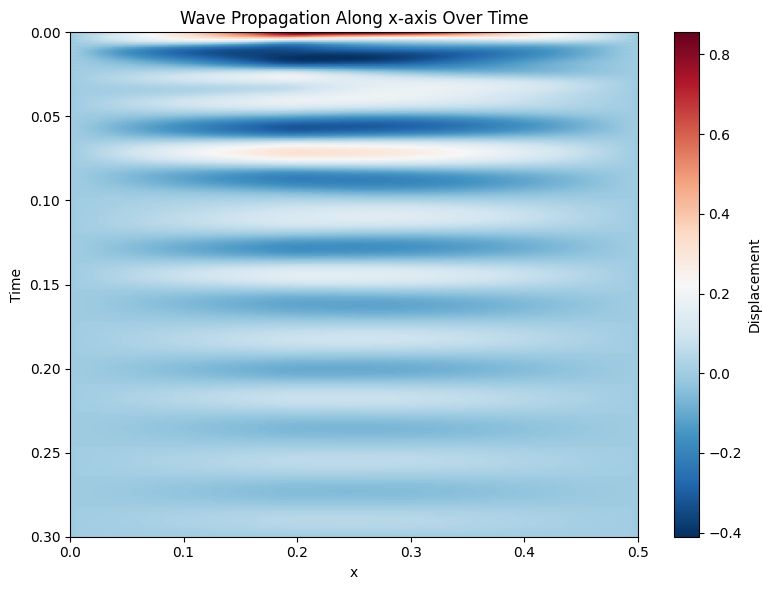

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Stack all wave fields into one array: shape (time, x, y)
u_array = np.array(u_hist)  # shape: (T, Nx, Ny)

# Pick a 1D cross-section (e.g. centerline y = Ny//2)
mid_y = Ny // 2
u_mid = u_array[:, :, mid_y]  # shape: (T, Nx)

# Create time-space grid
times = np.linspace(0, T, len(u_hist))
x_vals = np.linspace(0, Lx, Nx)

plt.figure(figsize=(8, 6))
plt.imshow(u_mid, aspect='auto', extent=[0, Lx, T, 0], cmap='RdBu_r')
plt.xlabel('x')
plt.ylabel('Time')
plt.title('Wave Propagation Along x-axis Over Time')
plt.colorbar(label='Displacement')
plt.tight_layout()
plt.show()
